In [1]:
import csv
import math
import json
import os
import cv2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
import scipy  

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preprocessing ###
Building up our training set, validation set and images from Pascal 2007 dataset.

In [2]:
path = os.getcwd()
dataset_path = os.path.join(os.getcwd(), "dataset/Annotations")
image_path = os.path.join(os.getcwd(), "dataset/JPEGImages")

train_path = os.path.join(dataset_path, "pascal_train2007.json")
val_path = os.path.join(dataset_path, "pascal_val2007.json")

# building up training dataset
with open(train_path) as f:
    train_data = json.load(f)

train_dataset = []
for image in train_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in train_data["annotations"]:
        if anno["image_id"] == image['id']:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    train_dataset.append(image_set)


# building up validation dataset    
with open(val_path) as f:
    val_data = json.load(f)
    
val_dataset = []
for image in val_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in val_data["annotations"]:
        if anno["image_id"] == image["id"]:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    val_dataset.append(image_set)

# redistribute list
combine_list = train_dataset + val_dataset
train_dataset = combine_list[:int(len(combine_list) * 0.8)]
val_dataset = combine_list[int(len(combine_list) * 0.8):]
    
# converter to convert id to label name
id_to_name = {c['id']:c['name'] for c in train_data['categories']}

print(train_data.keys())
print()
print("images: {}\n".format(train_data['images'][0]))
print("annotations: {}\n".format(train_data['annotations'][0]))
print("categories: {}\n".format(train_data['categories'][0]))

dict_keys(['type', 'images', 'annotations', 'categories'])

images: {'width': 500, 'file_name': '000012.jpg', 'id': 12, 'height': 333}

annotations: {'image_id': 12, 'ignore': 0, 'iscrowd': 0, 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'id': 1, 'category_id': 7, 'bbox': [155, 96, 196, 174]}

categories: {'supercategory': 'none', 'name': 'aeroplane', 'id': 1}



### Heatmap on MobileNet model ###

Following shows what our network have learned, by showing focus point through heatmap on image.
Red regions are places network learn to recognise, while blues are less important region to the our network. <br> 

#### How is it done? ####
By output the BatchNormalization and its connected weights to the next dense layer. We could extract the focus points learn by the network. This is then layered over the image as heatmap. This techique can be applied on custom  model that are using convolution layer, which we will discuss further later.

In [3]:
from keras.preprocessing import image
ALPHA = 1.0
IMAGE_SIZE = 224

'''
Convert image to preprocess_input
'''
def img_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

def mobileNet():
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=True, alpha=ALPHA)
    layer_weights = model.layers[-1].get_weights()[0]
    print(model.layers[-1])
    # output one of the BatchNormalization, Conv_1_bn (BatchNormalization) 
    model = Model(inputs=model.input, outputs=(model.layers[-4].output, model.layers[-1].output))
    return model, layer_weights


def mobileNet_CAM(img_path, model, layer_weights):    
    last_conv_output, pred_vec = model.predict(img_to_tensor(img_path))    
    last_conv_output = np.squeeze(last_conv_output)            
    pred = np.argmax(pred_vec)
    
    # bilinear upsampling to resize filtered image to size of orignal image
    # Zoom from (7, 7, 1280) to (224, 224, 1280)
    # mat_for_mult.shape = (224, 224, 1280)
    # layer_weights.shape = (1280, 1000)
    # amp_layer_weights.shape = (1280,)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32,32,1), order=1)
    amp_layer_weights = layer_weights[:, pred]    
    
    # Shape into 2D (224*224, 1280) to (224, 224)
    final_output = np.dot(mat_for_mult.reshape((224*224, 1280)), amp_layer_weights).reshape(224 ,224)
    return final_output, pred

def plot_CAM(img_path, ax, model, layer_weights):
    img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    ax.imshow(img, alpha=1.0)
    
    cam, pred = mobileNet_CAM(img_path, model, layer_weights)
    ax.imshow(cam, cmap='jet', alpha=0.5)

In [4]:
model, layer_weights = mobileNet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

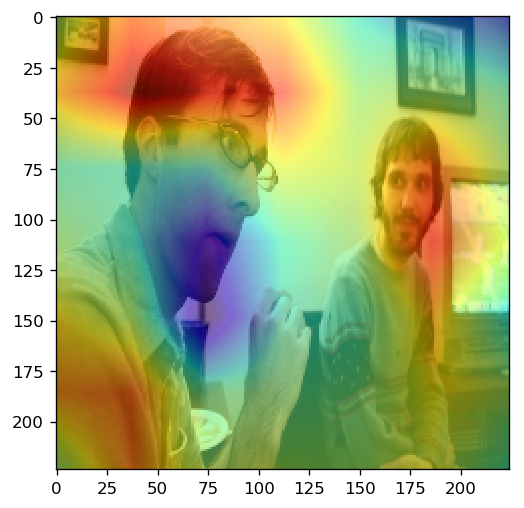

In [5]:
data = train_dataset[22]
img_path = os.path.join(image_path, data["image"]['file_name'])

fig, ax = plt.subplots(figsize=(5, 5), dpi= 120)
plot_CAM(img_path, ax, model, layer_weights)
plt.show()

### Heatmap on custom model ###

The following will view how custom model perform after training. Results show training cost network lose focus on certain images.

In [6]:
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.3

# training parameters
BATCH_SIZE = 64
# 96, 128, 160, 192, 224
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = True
THREADS = 4
AUG_IMAGE = False

class DataGenerator(Sequence):

    def __init__(self, dataset):
        self.paths = []
        self.coords = np.zeros((len(dataset), 4))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            width = data["image"]["width"]
            height = data["image"]["height"]
        
            x_scale = IMAGE_SIZE / width
            y_scale = IMAGE_SIZE / height
            x0, y0, x1, y1 = data['annotation']["bbox"]
                        
            self.coords[idx, 0] = int(x0 * x_scale)
            self.coords[idx, 1] = int(y0 * y_scale)
            self.coords[idx, 2] = int(x1 * x_scale)
            self.coords[idx, 3] = int(y1 * y_scale)
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # print("Range: {} {} ".format(idx * BATCH_SIZE, (idx + 1) * BATCH_SIZE))
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            ori_img = Image.open(f)
            img = ori_img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')            
            if(AUG_IMAGE):
                img = seq.augment_image(np.array(img))
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            ori_img.close()
        return batch_images, batch_coords

    
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0
        
        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]
            
            pred = np.maximum(pred, 0)
            
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)
            
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)
            
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse 
        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

        
def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers:
        layer.trainable = trainable

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4)(x)    
    
    batchNorm_layer = model.layers[-2].output
    
    return Model(inputs=model.input, outputs=(batchNorm_layer, x))

In [7]:
model = create_model()

WEIGHTS_FILE = "model-0.52.h5"
model.load_weights(WEIGHTS_FILE)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 40) 1080        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 40) 160         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [9]:
layer_weights = model.layers[-7].get_weights()[0]
print(model.layers[-7].name)
print(layer_weights.shape)

dense
(1664, 256)


In [10]:
import glob
from keras.preprocessing import image
import timeit

ALPHA = 1.0
IMAGE_SIZE = 224

'''
Convert image to preprocess_input
'''
def img_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

def mobileNet():
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=True, alpha=ALPHA)
    layer_weights = model.layers[-1].get_weights()[0]
    # output one of the BatchNormalization, Conv_1_bn (BatchNormalization) 
    model = Model(inputs=model.input, outputs=(model.layers[-4].output, model.layers[-1].output))
    return model, layer_weights


def mobileNet_CAM(img_path, model, layer_weights):    
    last_conv_output, pred_vec = model.predict(img_to_tensor(img_path))    
    last_conv_output = np.squeeze(last_conv_output)            
    pred = np.argmax(pred_vec)
    
    # bilinear upsampling to resize filtered image to size of orignal image
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32,32,1), order=1)
    # mat_for_mult = mat_for_mult.reshape((224, 224, 64))
    amp_layer_weights = layer_weights[:, pred]    

    # print(mat_for_mult.shape)
    # print(amp_layer_weights.shape)
    
    # Shape into 2D (224*224, 1280) to (224, 224)
    final_output = np.dot(mat_for_mult.reshape((224*224, 1664)), amp_layer_weights).reshape(224 ,224)
    return final_output, pred

def plot_CAM(img_path, ax, model, layer_weights):
    start_time = timeit.default_timer()
    
    img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    ax.imshow(img, alpha=1.0)
    
    cam, pred = mobileNet_CAM(img_path, model, layer_weights)
    ax.imshow(cam, cmap='jet', alpha=0.5)
    
    elapsed = timeit.default_timer() - start_time
    print("Time taken: {:.2f} sec".format(elapsed))
    

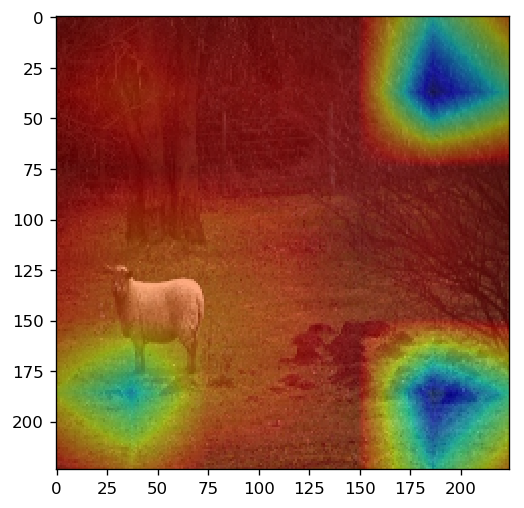

In [18]:
data = val_dataset[15]
img_path = os.path.join(image_path, data["image"]['file_name'])

fig, ax = plt.subplots(figsize=(5, 5), dpi= 120)
plot_CAM(img_path, ax, model, layer_weights)
plt.show()